In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

import warnings
import sys

from copy import deepcopy
import pickle

In [2]:
warnings.simplefilter("ignore")

howmanydifs = 3
allvalues_perset = pickle.load(open("allvalues_perset.p", "rb"))
methods = pickle.load(open("methods.p", "rb"))
fullsetnames = pickle.load(open("fullsetnames.p", "rb"))
functionals = pickle.load(open("functionals.p", "rb"))
basis_sets = pickle.load(open("basis_sets.p", "rb"))
supersetnames = pickle.load(open("supersetnames.p", "rb"))

In [3]:
# #for debug purposes
# for val in allvalues_perset:
#    print("======= START =======")
#    print(val, len(allvalues_perset[val]))
#    pp.pprint(allvalues_perset[val])
#    print("=======  END  =======")

In [4]:
# # Testing of WTMAD-2 function

# fullandsupersets = list(supersetnames.keys())
# fullandsupersets.append("Full")

# id_list = []
# lab_list = []
# pred_list = [] # To test the function, calculations using PBE-MINIX are being used

# for setname in fullsetnames:
#     if setname not in fullandsupersets:
#         for val in allvalues_perset[setname]:
#             id_list.append(setname)
#             lab_list.append(val['label'])
#             #pred_list.append(val['PBE-MINIX_energydiff']["PBE-MINIX_FINAL_SINGLE_POINT_ENERGY"])
#             pred_list.append(val['label']+val['difs'][2]) #This line allowed to test the WTMAD-2 calculation by operating over reference data


# from commonutils import wtmad2

# # WTMAD2 calculation for reference values just as example:

# wtmad2 = wtmad2(id_list,lab_list,pred_list)

# print(wtmad2)

In [5]:
from importlib import reload
reload(commonutils)

from commonutils import ModelResults

allfeatures = set()
for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)

# set labels and sets lists
models_results = {}
for setname in fullsetnames:
    models_results[setname] = ModelResults()
    for val in allvalues_perset[setname]:
        models_results[setname].labels.append(val["label"]) 
        models_results[setname].supersetnames.append(val["super_setname"])
        models_results[setname].setnames.append(val["super_setname"]+"_"+val["setname"])


insidemethods = ["W","D3(0)","D3(BJ)"]
superset_list = list(supersetnames.keys())
superset_list.append("Full")

for setname in fullsetnames:
    for methodid in range(howmanydifs):
        y_pred = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])

        if setname in superset_list:
            wtmadf = commonutils.wtmad2(models_results[setname].setnames, \
                                        models_results[setname].labels, y_pred)
            wtmad = wtmadf[setname]

            if wtmad < models_results[setname].bestinsidemethod_wtmad:
                models_results[setname].bestinsidemethod_wtmad = wtmad
                models_results[setname].bestinsidemethod_name_wtmad = insidemethods[methodid]
                models_results[setname].y_pred_bestinsidemethod_wtmad = y_pred

        else:
            models_results[setname].bestinsidemethod_wtmad = float("NaN")
            models_results[setname].bestinsidemethod_name_wtmad = ""
            models_results[setname].y_pred_bestinsidemethod_wtmad = y_pred

        rmse = mean_squared_error(models_results[setname].labels, \
                                y_pred, squared=False)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod_name_rmse = insidemethods[methodid]
            models_results[setname].y_pred_bestinsidemethod_rmse = y_pred

    for j, method in enumerate(methods):
        y_pred = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])

        if setname in superset_list:

            wtmadf = commonutils.wtmad2(models_results[setname].setnames, \
                                    models_results[setname].labels, y_pred)
            wtmad = wtmadf[setname]

            if wtmad < models_results[setname].bestourmethod_wtmad:
                models_results[setname].bestourmethod_wtmad = wtmad
                models_results[setname].bestourmethod_name_wtmad = method
                models_results[setname].y_pred_bestourmethod_wtmad = y_pred

        else:
            models_results[setname].bestourmethod_wtmad = float("NaN")
            models_results[setname].bestourmethod_name_wtmad = ""
            models_results[setname].y_pred_bestourmethod_wtmad = y_pred
        
        rmse = mean_squared_error(models_results[setname].labels,\
                                y_pred, squared=False)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod_name_rmse = method
            models_results[setname].y_pred_bestourmethod_rmse = y_pred

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
    "Best inside method RMSE", " , ", \
    "RMSE", " , ", \
    "Best inside method WTMAD2", " , ", \
    "WTMAD2", " , ", \
    "Best our method RMSE", " , ", \
    "RMSE", " , ", \
    "Best our method WTMAD2", " , ", \
    "WTMAD2")
for setname in superset_list:
    print("%40s"%setname, " , ", \
        "%10s"%models_results[setname].bestinsidemethod_name_rmse , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%10s"%models_results[setname].bestinsidemethod_name_wtmad , " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_wtmad, " , ", \
        "%10s"%models_results[setname].bestourmethod_name_rmse , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%10s"%models_results[setname].bestourmethod_name_wtmad , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_wtmad)

Results for inside and our methods
                                 Dataset  ,  Best inside method RMSE  ,  RMSE  ,  Best inside method WTMAD2  ,  WTMAD2  ,  Best our method RMSE  ,  RMSE  ,  Best our method WTMAD2  ,  WTMAD2
                         BARRIER_HEIGHTS  ,           W  ,    8.201  ,           W  ,   17.010  ,    PBE-QZVP  ,    8.871  ,    PBE-QZVP  ,   18.910
             INTRAMOLECULAR_INTERACTIONS  ,      D3(BJ)  ,    0.873  ,       D3(0)  ,    8.630  ,    PBE-QZVP  ,    0.874  ,    PBE-QZVP  ,    9.650
                         SMALL_MOLECULES  ,           W  ,   12.191  ,       D3(0)  ,    6.750  ,    PBE-QZVP  ,   12.532  ,    PBE-QZVP  ,    6.840
             INTERMOLECULAR_INTERACTIONS  ,           W  ,    2.286  ,       D3(0)  ,    9.470  ,    PBE-QZVP  ,    5.052  ,    PBE-QZVP  ,   10.900
                           LARGE_SYSTEMS  ,       D3(0)  ,   12.567  ,      D3(BJ)  ,   12.500  ,    PBE-QZVP  ,   13.466  ,    PBE-QZVP  ,   12.470
                             

In [6]:
#build descriptors 
reference_basisset = "TZP"
selected_functional = "PBE"
selected_basissets = ["SVP","TZVP"]
functionals = ["PBE"]
descriptors_to_use = ["All"]

hamiltonian = True
hamiltonian_terms = ["Kinetic_Energy","Nuclear_Repulsion",\
                     "One_Electron_Energy","Two_Electron_Energy",\
                     "Dispersion_correction"]

energy_decomposition = False
edecomp_terms = ["Kinetic_Energy","Nuclear_Repulsion",\
                 "One_Electron_Energy","Two_Electron_Energy",\
                 "E(X)","E(C)","Dispersion_correction"]

if hamiltonian == True:
    descriptors_to_use = hamiltonian_terms

if energy_decomposition == True:
    descriptors_to_use = edecomp_terms


for setname in fullsetnames:
    descriptors = {}
    for val in allvalues_perset[setname]:
        for func in functionals:
            for basis in selected_basissets:
                if basis == reference_basisset and func == selected_functional:
                    ham = func + "-" + basis
                    k = func + "-" + basis + "_energydiff"
                    for k2 in val[k]:
                        if any(k2.endswith(descr) for descr in descriptors_to_use):
                            if k2 not in descriptors:
                                descriptors[k2] = [val[k][k2]]
                            else:
                                descriptors[k2].append(val[k][k2])
                        elif descriptors_to_use[0]=="All":
                            if k2 not in descriptors:
                                descriptors[k2] = [val[k][k2]]
                            else:
                                descriptors[k2].append(val[k][k2])

                    if hamiltonian == True:

                        descriptors[ham+"_Electron_Repulsion"]=\
                            descriptors[ham+"_Two_Electron_Energy"]
                        
                        descriptors[ham+"_Nuclei_Electron_Attraction"]=\
                            [one-k for one,k in zip(descriptors[ham+"_One_Electron_Energy"],\
                                                    descriptors[ham+"_Kinetic_Energy"])]
                            

                    if energy_decomposition == True:

                        descriptors[ham+"_Coulomb_Interaction"]=\
                            [two-X-C for two,X,C in zip(descriptors[ham+"_Two_Electron_Energy"],\
                                                        descriptors[ham+"_E(X)"],descriptors[ham+"_E(C)"])]
                        
                        descriptors[ham+"_Nuclei_Electron_Attraction"]=\
                            [one-k for one,k in zip(descriptors[ham+"_One_Electron_Energy"],\
                                                    descriptors[ham+"_Kinetic_Energy"])]


                else:
                    refk  = selected_functional + "-" + reference_basisset + "_energydiff"
                    k = func + "-" + basis + "_energydiff"
                    ham = func + "-" + basis
                    for k2 in val[k]:
                        if any(k2.endswith(descr) for descr in descriptors_to_use):
                            refk2 = k2.replace(basis, reference_basisset)
                            refk2 = refk2.replace(func, selected_functional)
                            newk2 = k2 + "_difftoref"
                            if newk2 not in descriptors:
                                descriptors[newk2] = [val[refk][refk2] - val[k][k2]]
                            else:
                                descriptors[newk2].append(val[refk][refk2] - val[k][k2])
                        elif descriptors_to_use[0]=="All":
                            refk2 = k2.replace(basis, reference_basisset)
                            refk2 = refk2.replace(func, selected_functional)
                            newk2 = k2 + "_difftoref"
                            if newk2 not in descriptors:
                                descriptors[newk2] = [val[refk][refk2] - val[k][k2]]
                            else:
                                descriptors[newk2].append(val[refk][refk2] - val[k][k2])

                    if hamiltonian == True:

                        descriptors[ham+"_Electron_Repulsion_difftoref"]=\
                            descriptors[ham+"_Two_Electron_Energy_difftoref"]
                        
                        descriptors[ham+"_Nuclei_Electron_Attraction_difftoref"]=\
                            [one-k for one,k in zip(descriptors[ham+"_One_Electron_Energy_difftoref"],\
                                                    descriptors[ham+"_Kinetic_Energy_difftoref"])]

                    if energy_decomposition == True:
                        
                        descriptors[ham+"_Coulomb_Interaction_difftoref"]=\
                            [two-X-C for two,X,C in zip(descriptors[ham+"_Two_Electron_Energy_difftoref"],\
                                                        descriptors[ham+"_E(X)_difftoref"],descriptors[ham+"_E(C)_difftoref"])]
                        
                        descriptors[ham+"_Nuclei_Electron_Attraction_difftoref"]=\
                            [one-k for one,k in zip(descriptors[ham+"_One_Electron_Energy_difftoref"],\
                                                    descriptors[ham+"_Kinetic_Energy_difftoref"])]


    if hamiltonian == True or energy_decomposition == True:
        extra_descriptors = ["Two_Electron_Energy","One_Electron_Energy"]
        keys_to_delete = [key for key in descriptors if any(exdesc in key for exdesc in extra_descriptors)]
        for key in keys_to_delete:
            del descriptors[key]

    models_results[setname].features = descriptors
    #print("Descriptors for ", setname)
    #for k in descriptors:
    #    print(k, len(descriptors[k]), descriptors[k])

# feastures selection
setname = "Full"
numoffeat = len(models_results[setname].features)
print("Number of features for ", numoffeat)
for setname in fullsetnames:
    if len(models_results[setname].features) != numoffeat:
        print("Number of features for ", setname, " is different")
        sys.exit(1)

toremove = []
setname = "Full"
for k in models_results[setname].features:
    if len(set(models_results[setname].features[k])) == 1:
        toremove.append(k)
        print("Constant fatures to remove: ", k)

# remove constant values
for setname in fullsetnames:
    #print("Removing constant features for ", setname)
    for k in toremove:
        #print("Constant fatures to remove: ", k)
        del models_results[setname].features[k]

# test print for debug
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    for k in models_results[setname].features:
#        print(k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])

# force removing features Nuclear Repulsion difference
print("Removing Nuclear Repulsion difference")
for setname in fullsetnames: 
    toremove = []
    for k in models_results[setname].features:
        if k.find("Nuclear_Repulsion_difftoref") != -1:
            toremove.append(k)
    for k in toremove:
        #print("Removing feature ", k)
        del models_results[setname].features[k]

setname = "Full"
numoffeat = len(models_results[setname].features)
print("Number of features for ", numoffeat)
for setname in fullsetnames:
    if len(models_results[setname].features) != numoffeat:
        print("Number of features for ", setname, " is different")
        sys.exit(1)

Number of features for  10
Constant fatures to remove:  PBE-TZVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  PBE-TZVP_Dispersion_correction_difftoref
Removing Nuclear Repulsion difference
Number of features for  8


In [7]:
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    for k in models_results[setname].features:
#        print(k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])

In [8]:
# remove corralted features 
CORRCUT = 1

setname = "Full"
touse = set()
# add by default the selected FINAL_SINGLE_POINT_ENERGY
toremove = set()
df = pd.DataFrame(models_results[setname].features)
corr = df.corr().abs()
for i, k in enumerate(corr.columns):
    print(i+1, " - ", k, " ", i)
    if k not in toremove:
        touse.add(k)
    for idx, v in enumerate(corr[k]):
        if v > CORRCUT and idx > i:
            print(" %60s %4.2f"%(corr.index[idx], v))
            if corr.index[idx] not in touse:
                toremove.add(corr.index[idx])

print("Features to use")
for i, feat in enumerate(touse):
    print(i+1 ,  " - " , feat)

for setname in fullsetnames:
    for k in touse:
        models_results[setname].uncorrelated_features[k] = \
            deepcopy(models_results[setname].features[k])

1  -  PBE-SVP_Dispersion_correction   0
2  -  PBE-SVP_Kinetic_Energy   1
3  -  PBE-SVP_Nuclear_Repulsion   2
4  -  PBE-SVP_Electron_Repulsion   3
5  -  PBE-SVP_Nuclei_Electron_Attraction   4
6  -  PBE-TZVP_Kinetic_Energy_difftoref   5
7  -  PBE-TZVP_Electron_Repulsion_difftoref   6
8  -  PBE-TZVP_Nuclei_Electron_Attraction_difftoref   7
Features to use
1  -  PBE-SVP_Dispersion_correction
2  -  PBE-SVP_Kinetic_Energy
3  -  PBE-TZVP_Nuclei_Electron_Attraction_difftoref
4  -  PBE-SVP_Electron_Repulsion
5  -  PBE-SVP_Nuclei_Electron_Attraction
6  -  PBE-SVP_Nuclear_Repulsion
7  -  PBE-TZVP_Kinetic_Energy_difftoref
8  -  PBE-TZVP_Electron_Repulsion_difftoref


Correlation matrix


<Axes: >

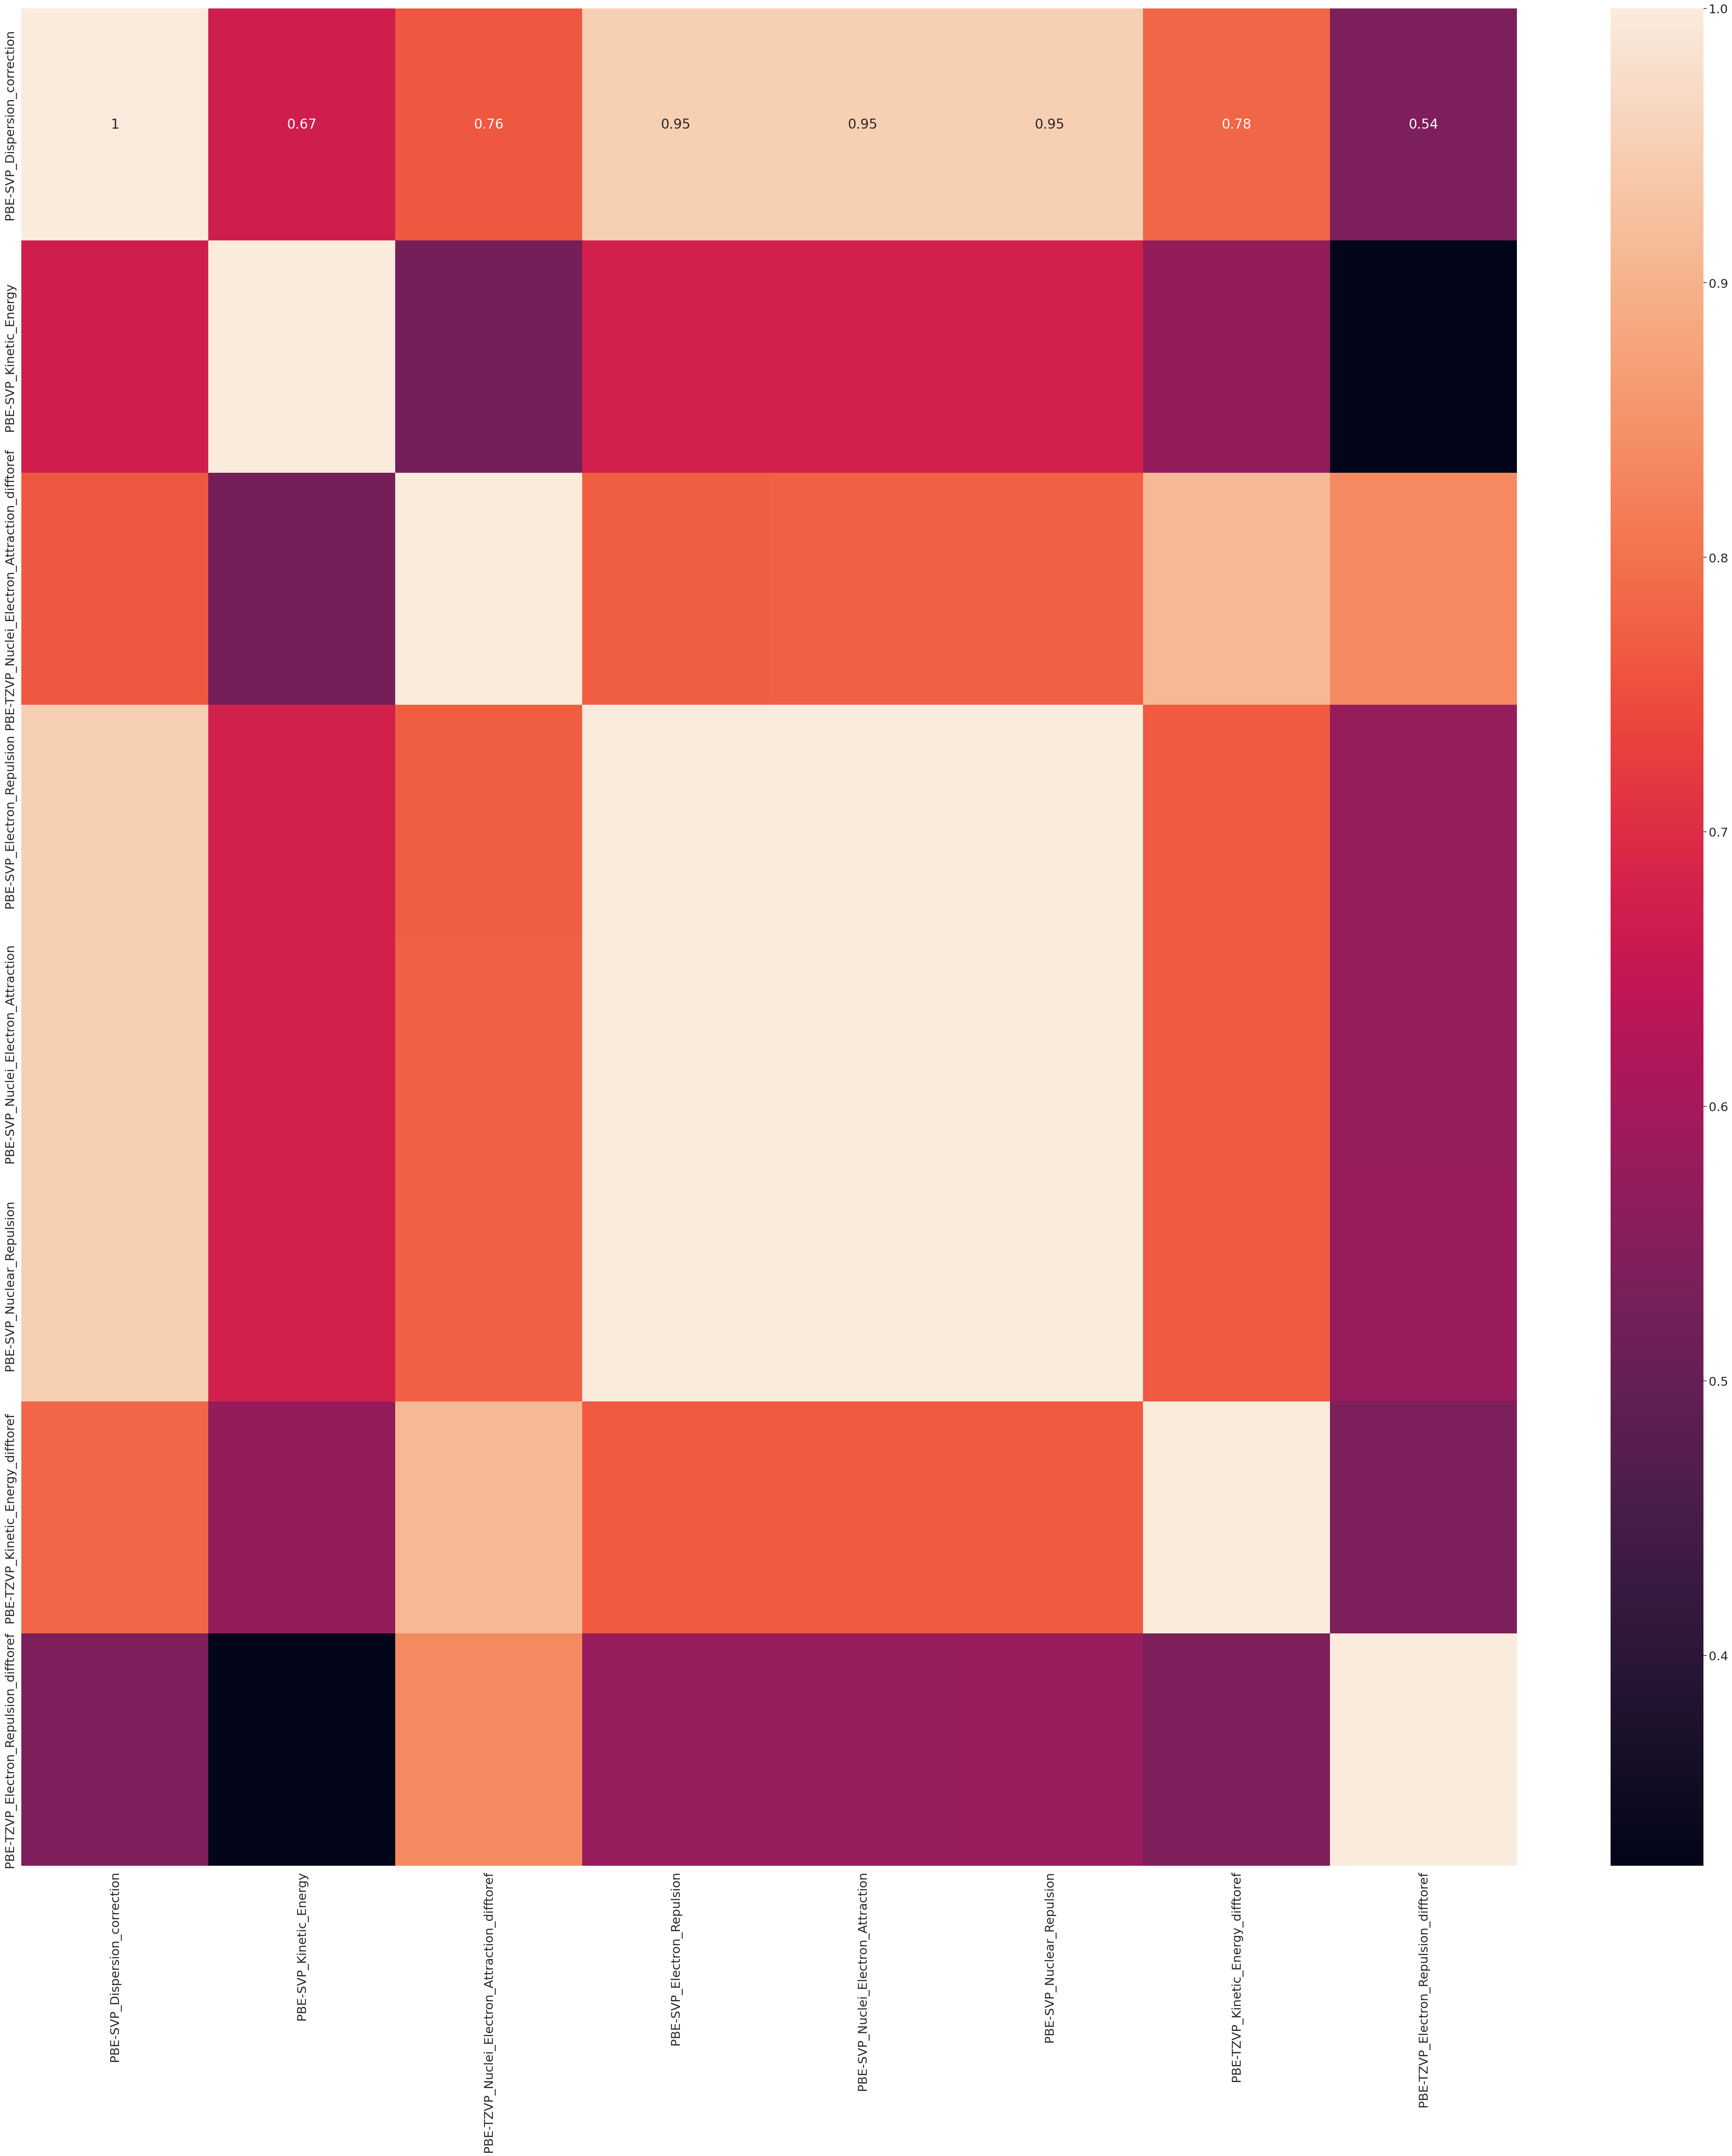

In [9]:
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    i = 1
#    for k in models_results[setname].features:
#        print(i, " - ", k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])
#        i += 1

import seaborn as sns
%matplotlib inline

setname = "Full"
df = pd.DataFrame(models_results[setname].uncorrelated_features)
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 60,60
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)
#print(df.corr().abs())
#sns.heatmap(df, annot=True)

In [10]:
import importlib
importlib.reload(models)
importlib.reload(commonutils)

perc_split = 0.2
for setname in list(supersetnames)+["Full"]:
   print("Running Quantile Regression for dataset: ", setname)

   X, Y, features_names = \
      commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
              models_results[setname].labels)
   setlist = []
   for i, s in enumerate(models_results[setname].setnames):
        ss = models_results[setname].supersetnames[i]
        setlist.append(s)  
   supersetlist = models_results[setname].supersetnames
   rmse_train, rmse_test, r2_train, \
      r2_test, rmse_full, r2_full , \
      models_results[setname].qregmodel, \
      X_train, X_test, y_train, y_test  = \
              models.qr_model(perc_split, X, Y, supersetlist, setlist, \
                              split = True)
   
   models_results[setname].y_pred = \
      models_results[setname].qregmodel.predict(X) 

Running Quantile Regression for dataset:  BARRIER_HEIGHTS
Running Quantile Regression for dataset:  INTRAMOLECULAR_INTERACTIONS
Running Quantile Regression for dataset:  SMALL_MOLECULES
Running Quantile Regression for dataset:  INTERMOLECULAR_INTERACTIONS
Running Quantile Regression for dataset:  LARGE_SYSTEMS
Running Quantile Regression for dataset:  Full


In [11]:
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE (superset) ," + \
      "RMSE (Full)")
qreg_model_full = models_results["Full"].qregmodel
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results["Full"].uncorrelated_features, \
                                    models_results["Full"].labels)
y_pred = qreg_model_full.predict(X)
rmse = mean_squared_error(Y, y_pred, squared=False)
r2 = r2_score(Y, y_pred)
print("%4d , %40s"%(len(models_results["Full"].labels), "Full"), " , ", \
    "%7.3f"%models_results["Full"].bestinsidemethod_rmse, " , ", \
    "%7.3f"%models_results["Full"].bestourmethod_rmse, " , ", \
    "%7.3f"%rmse, " , ", \
    "%7.3f"%rmse)

for ssetname in supersetnames:
    qreg_model_ssetname = models_results[ssetname].qregmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[ssetname].uncorrelated_features, \
                                    models_results[ssetname].labels)
    y_pred = qreg_model_ssetname.predict(X)
    rmse = mean_squared_error(Y, y_pred, squared=False)

    y_pred_full = qreg_model_full.predict(X) 
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)

    print("%4d , %40s"%(len(models_results[ssetname].labels), ssetname), " , ", \
        "%7.3f"%models_results[ssetname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[ssetname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%rmse_full)
    
    for isetname in supersetnames[ssetname]:
        setname = ssetname + "_" + isetname 
        X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)

        y_pred_ssetname = qreg_model_ssetname.predict(X)
        rmse_ssetname = mean_squared_error(Y, y_pred_ssetname, squared=False)

        y_pred_full = qreg_model_full.predict(X)
        rmse_full = mean_squared_error(Y, y_pred_full, squared=False)

        print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
            "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
            "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
            "%7.3f"%rmse_ssetname, " , ", \
            "%7.3f"%rmse_full)


 Dim ,                                  Dataset  ,  Best inside method RMSE  ,  Best our method RMSE  ,  RMSE (superset) ,RMSE (Full)
1505 ,                                     Full  ,    9.227  ,    9.700  ,   11.736  ,   11.736
 194 ,                          BARRIER_HEIGHTS  ,    8.201  ,    8.871  ,   10.377  ,   16.054
  76 ,                     BARRIER_HEIGHTS_BH76  ,   10.387  ,   10.946  ,    8.112  ,   11.216
  10 ,                  BARRIER_HEIGHTS_BHDIV10  ,    9.191  ,    9.876  ,   10.313  ,   10.292
  26 ,                   BARRIER_HEIGHTS_BHPERI  ,    4.407  ,    6.902  ,    4.640  ,    5.171
  27 ,                  BARRIER_HEIGHTS_BHROT27  ,    0.611  ,    0.653  ,    8.789  ,    3.999
  24 ,                    BARRIER_HEIGHTS_INV24  ,    2.658  ,    2.372  ,   21.417  ,   39.252
  13 ,                     BARRIER_HEIGHTS_PX13  ,   11.730  ,   12.244  ,    5.383  ,    8.178
  18 ,                   BARRIER_HEIGHTS_WCPT18  ,    8.999  ,    9.848  ,    6.653  ,    4.733
 2

Results for  BARRIER_HEIGHTS  dim:  194
WTMAD2       QReg Full, 21.460
WTMAD2  QReg Super Set, 22.000
WTMAD2               W, 17.010
WTMAD2        PBE-QZVP, 18.910
RMSE         QReg Full, 16.054
RMSE    QReg Super Set, 10.377
RMSE                 W,  8.201
RMSE          PBE-QZVP,  8.871


<Figure size 6000x6000 with 0 Axes>

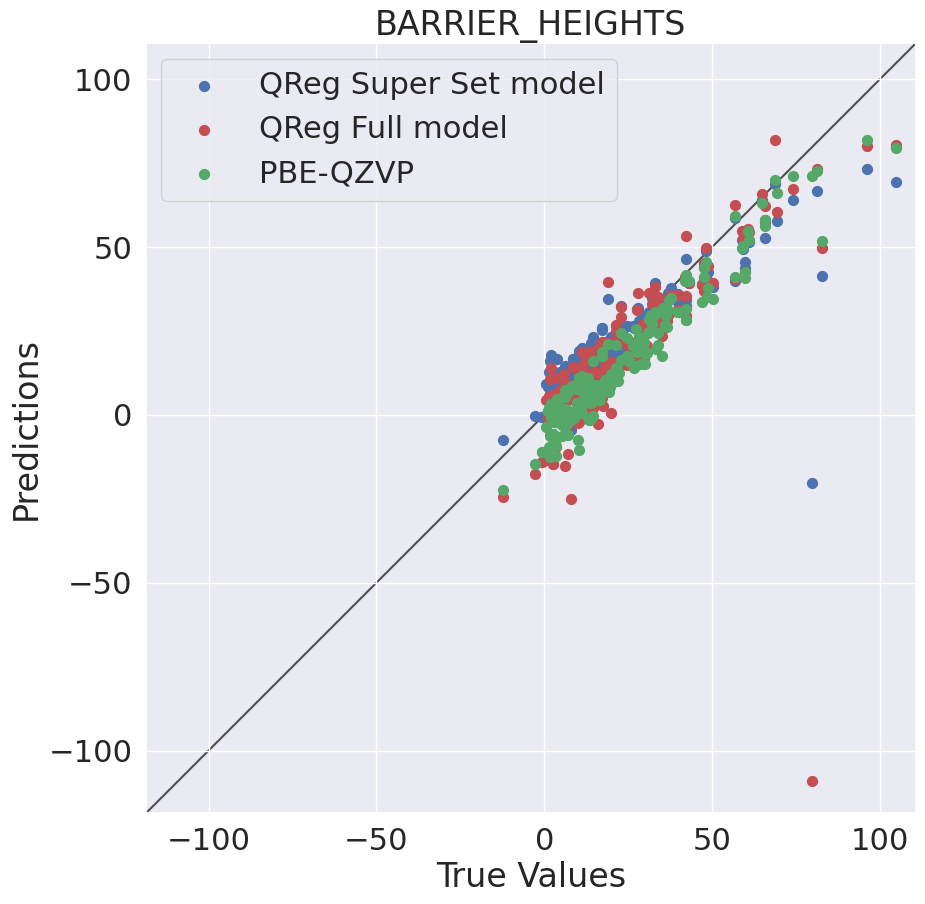

Results for  INTRAMOLECULAR_INTERACTIONS  dim:  291
WTMAD2       QReg Full, 29.860
WTMAD2  QReg Super Set, 28.490
WTMAD2           D3(0),  8.630
WTMAD2        PBE-QZVP,  9.650
RMSE         QReg Full,  4.053
RMSE    QReg Super Set,  4.401
RMSE            D3(BJ),  0.873
RMSE          PBE-QZVP,  0.874


<Figure size 1000x1000 with 0 Axes>

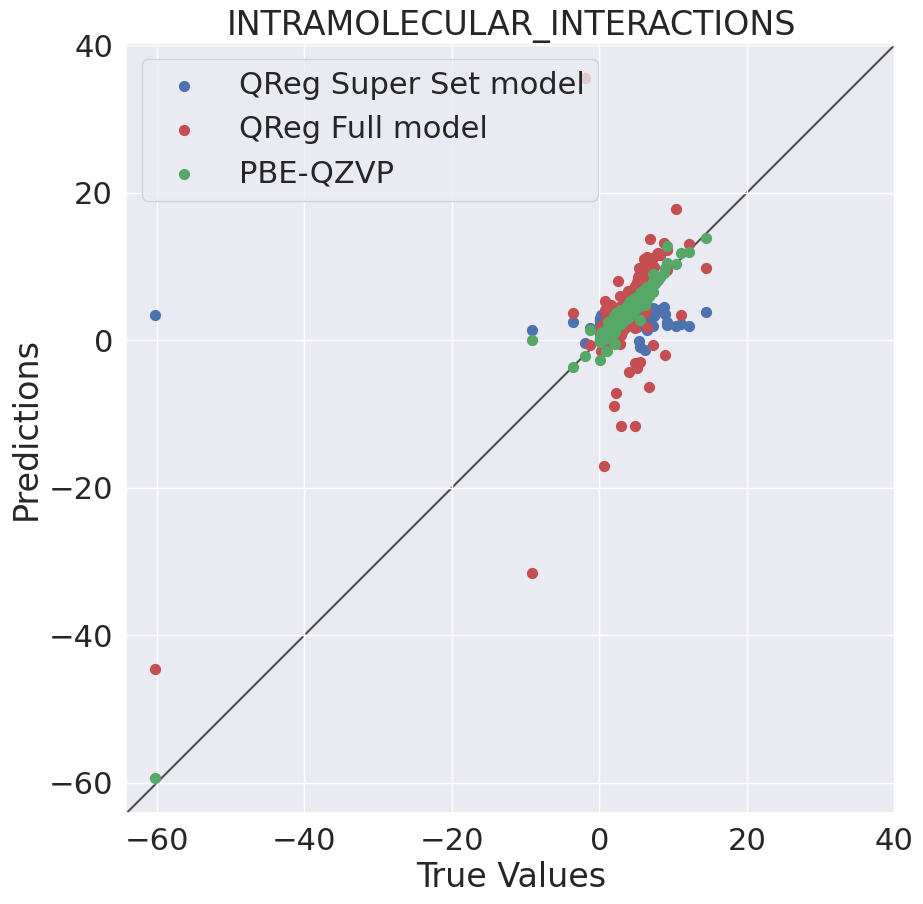

Results for  SMALL_MOLECULES  dim:  473
WTMAD2       QReg Full,  9.840
WTMAD2  QReg Super Set, 10.450
WTMAD2           D3(0),  6.750
WTMAD2        PBE-QZVP,  6.840
RMSE         QReg Full, 11.572
RMSE    QReg Super Set, 11.585
RMSE                 W, 12.191
RMSE          PBE-QZVP, 12.532


<Figure size 1000x1000 with 0 Axes>

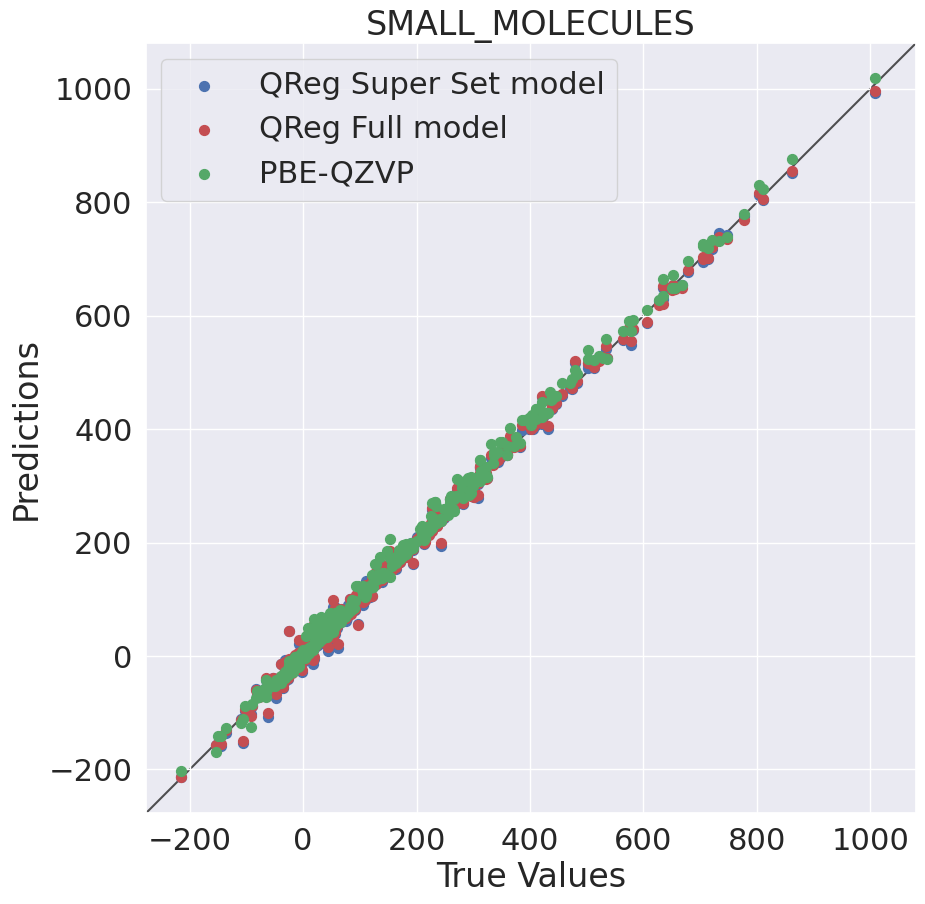

Results for  INTERMOLECULAR_INTERACTIONS  dim:  304
WTMAD2       QReg Full, 55.840
WTMAD2  QReg Super Set, 16.500
WTMAD2           D3(0),  9.470
WTMAD2        PBE-QZVP, 10.900
RMSE         QReg Full, 10.388
RMSE    QReg Super Set,  6.391
RMSE                 W,  2.286
RMSE          PBE-QZVP,  5.052


<Figure size 1000x1000 with 0 Axes>

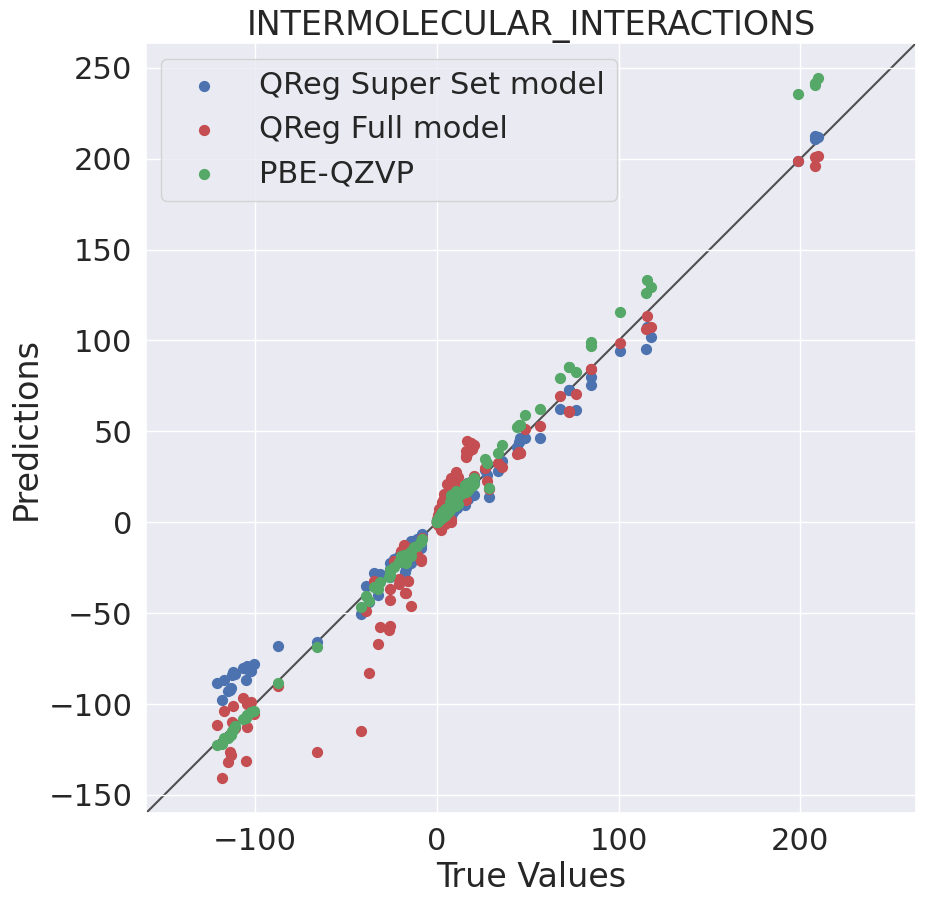

Results for  LARGE_SYSTEMS  dim:  243
WTMAD2       QReg Full, 14.560
WTMAD2  QReg Super Set, 13.190
WTMAD2          D3(BJ), 12.500
WTMAD2        PBE-QZVP, 12.470
RMSE         QReg Full, 15.231
RMSE    QReg Super Set, 11.846
RMSE             D3(0), 12.567
RMSE          PBE-QZVP, 13.466


<Figure size 1000x1000 with 0 Axes>

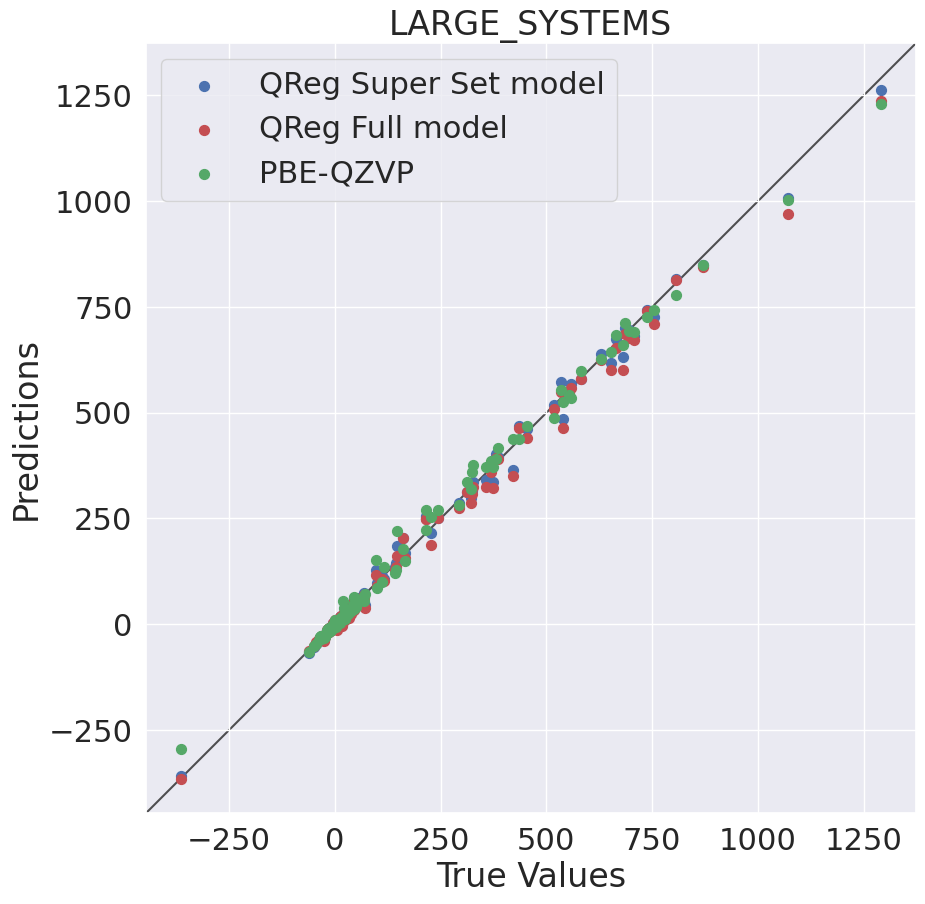

Results for Full sim  1505
WTMAD2       QReg Full, 25.270
WTMAD2  QReg Super Set, 17.090
WTMAD2           D3(0), 10.160
WTMAD2        PBE-QZVP, 10.670
RMSE         QReg Full, 11.736
RMSE    QReg Super Set,  9.525
RMSE             D3(0),  9.227
RMSE          PBE-QZVP,  9.700


<Figure size 1000x1000 with 0 Axes>

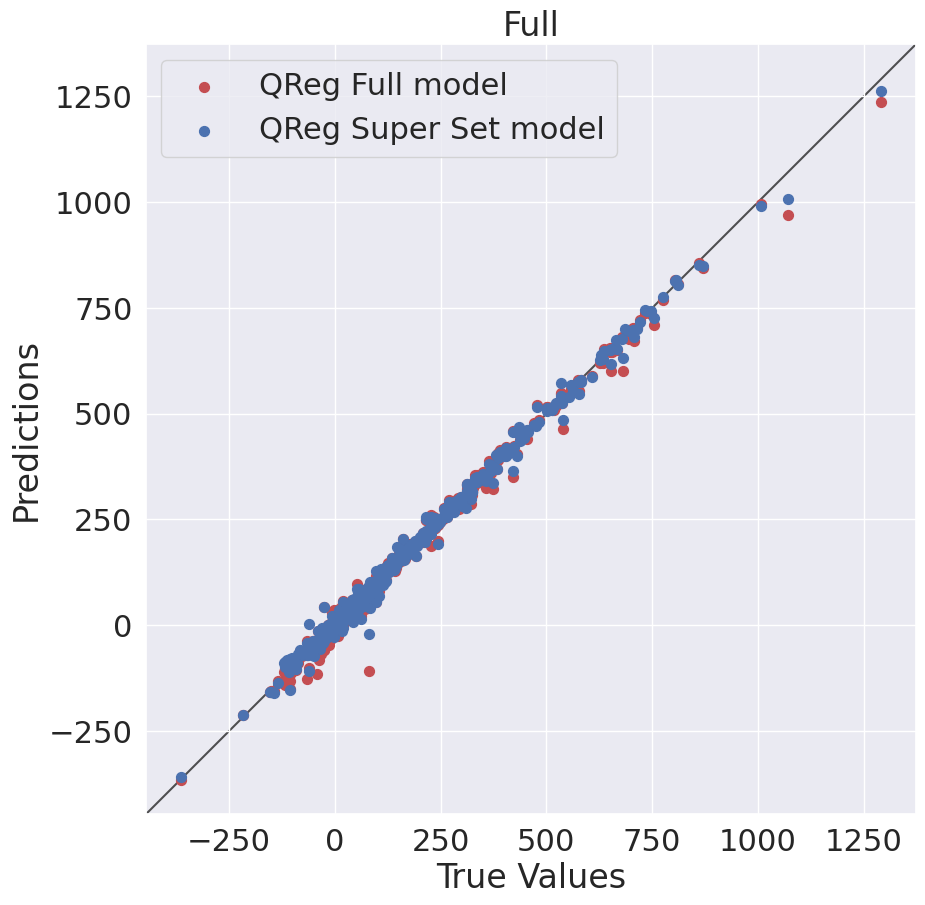

In [12]:
setname = "Full"
qreg_model_full = models_results[setname].qregmodel
printonlysuperset = True
setnametouse = deepcopy(fullsetnames)
setnametouse.remove("Full")

ypredFull = []
setnamesFull = []

for setname in setnametouse:
    if setname in supersetnames:
        ssetname = setname  
    else:    
        lastunder = setname.rfind("_")
        ssetname = setname[:lastunder]
    
    qreg_model_ssetname = models_results[ssetname].qregmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)
    setlist = []
    for i, s in enumerate(models_results[setname].setnames):
        ss = models_results[setname].supersetnames[i]
        setlist.append(s)   
    y_pred_full = qreg_model_full.predict(X)
    if len(y_pred_full.shape) == 2:
        y_pred_full = y_pred_full[:,0]
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)

    y_pred = qreg_model_ssetname.predict(X)
    if len(y_pred.shape) == 2:
        y_pred = y_pred[:,0]
    rmse = mean_squared_error(Y, y_pred, squared=False)
    
    if setname in supersetnames:
        ypredFull.extend(list(y_pred))
        setnamesFull.extend(setlist)
        print("Results for ", setname, " dim: ", len(Y))
        wtmad2df = commonutils.wtmad2(setlist, Y, y_pred)
        wtmad2_fulldf = commonutils.wtmad2(setlist, Y, y_pred_full)
        wtmad2 = wtmad2df[setname]
        wtmad2_full = wtmad2_fulldf[setname] #When analysing supersets, WTMAD2 SS and Full should be equal
        
        print("WTMAD2","%15s,%7.3f"%("QReg Full",wtmad2_full))
        print("WTMAD2","%15s,%7.3f"%("QReg Super Set",wtmad2))
        print("WTMAD2","%15s,%7.3f"%(models_results[setname].bestinsidemethod_name_wtmad, models_results[setname].bestinsidemethod_wtmad))
        print("WTMAD2","%15s,%7.3f"%(models_results[setname].bestourmethod_name_wtmad, models_results[setname].bestourmethod_wtmad))
        
    if printonlysuperset and setname not in list(supersetnames.keys()) + ["Full"]:
        continue
    
    print("RMSE  ","%15s,%7.3f"%("QReg Full", rmse_full))
    print("RMSE  ","%15s,%7.3f"%("QReg Super Set",rmse))
    print("RMSE  ","%15s,%7.3f"%(models_results[setname].bestinsidemethod_name_rmse,models_results[setname].bestinsidemethod_rmse))
    print("RMSE  ","%15s,%7.3f"%(models_results[setname].bestourmethod_name_rmse,models_results[setname].bestourmethod_rmse))
    
    plt.clf()
    plt.rcParams['figure.figsize'] = 10,10
    fig, ax = plt.subplots()
    ax.scatter(Y, y_pred, c='b', s=50, label='QReg Super Set model')
    ax.scatter(Y, y_pred_full, c='r', s=50, label='QReg Full model')
    #ax.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
    #            c='r', s=50, label='Best inside method')
    ax.scatter(Y, models_results[setname].y_pred_bestourmethod_rmse, \
               c='g', s=50, label=f"{models_results[setname].bestourmethod_name_rmse}")
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend(loc="upper left")
    plt.title(setname)
    plt.show()

print("Results for Full sim ", len(ypredFull))
X, Y, features_names = \
        commonutils.build_XY_matrix (models_results["Full"].uncorrelated_features, \
                                    models_results["Full"].labels)
setlist = []
for i, s in enumerate(models_results["Full"].setnames):
    ss = models_results["Full"].supersetnames[i]
    setlist.append(s)   
wtmad2df = commonutils.wtmad2(setnamesFull, Y, ypredFull)
wtmad2 = wtmad2df["Full"]
rmse = mean_squared_error(Y, ypredFull, squared=False)

y_pred_full = qreg_model_full.predict(X)
if len(y_pred_full.shape) == 2:
    y_pred_full = y_pred_full[:,0]
rmse_full = mean_squared_error(Y, y_pred_full, squared=False)
wtmad2_fulldf = commonutils.wtmad2(setnamesFull, Y, y_pred_full)
wtmad2_full = wtmad2_fulldf["Full"]

print("WTMAD2","%15s,%7.3f"%("QReg Full",wtmad2_full))
print("WTMAD2","%15s,%7.3f"%("QReg Super Set",wtmad2))
print("WTMAD2","%15s,%7.3f"%(models_results['Full'].bestinsidemethod_name_wtmad,models_results["Full"].bestinsidemethod_wtmad))
print("WTMAD2","%15s,%7.3f"%(models_results['Full'].bestourmethod_name_wtmad, models_results["Full"].bestourmethod_wtmad))

rmse = mean_squared_error(models_results["Full"].labels, ypredFull, squared=False)

print("RMSE  ","%15s,%7.3f"%("QReg Full", rmse_full))
print("RMSE  ","%15s,%7.3f"%("QReg Super Set", rmse))
print("RMSE  ","%15s,%7.3f"%(models_results['Full'].bestinsidemethod_name_rmse, models_results["Full"].bestinsidemethod_rmse))
print("RMSE  ","%15s,%7.3f"%(models_results['Full'].bestourmethod_name_rmse, models_results["Full"].bestourmethod_rmse))

plt.clf()
plt.rcParams['figure.figsize'] = 10,10
fig, ax = plt.subplots()
ax.scatter(Y, y_pred_full, c='r', s=50, label='QReg Full model')
ax.scatter(Y, ypredFull, c='b', s=50, label='QReg Super Set model')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend(loc="upper left")
plt.title("Full")
plt.show()


In [13]:
# #test and dump PLS equations
# setname = "Full"
# huber_model_full = models_results[setname].plsmodel

# for setname in fullsetnames:
#     print("Equations for dataset: ", setname)
#     ssetname = "Full"
#     if setname in supersetnames or setname == "Full":
#         ssetname = setname  
#     else:    
#         lastunder = setname.rfind("_")
#         ssetname = setname[:lastunder]
    
#     huber_model_ssetname = models_results[ssetname].hubermodel
#     X, Y, features_names = \
#         commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
#                                     models_results[setname].labels)
    
#     y_pred_full = huber_model_full.predict(X)
#     rmse_full = mean_squared_error(Y, y_pred_full, squared=False)
#     r2_full = r2_score(Y, y_pred_full)
#     X_e = X.copy()
#     X_e -= huber_model_full._x_mean
#     X_e /= huber_model_full._x_std
#     y_pred_full_e = np.dot(X_e, huber_model_full.coef_.T)
#     y_pred_full_e += huber_model_full._y_mean
#     rmse_full_e = mean_squared_error(Y, y_pred_full_e, squared=False)
#     print("   Full dataset equations Y mean %7.3f"%huber_model_full._y_mean)
#     for i, f in enumerate(features_names):
#         print(" %50s %7.3f [%15.3f %15.3f]"%(f, \
#             huber_model_full.coef_.T[i]))

#     y_pred = huber_model_ssetname.predict(X)
#     rmse = mean_squared_error(Y, y_pred, squared=False)
#     r2 = r2_score(Y, y_pred)
#     X_e = X.copy()
#     X_e -= pls_model_ssetname._x_mean
#     X_e /= pls_model_ssetname._x_std
#     y_pred_e = np.dot(X_e, pls_model_ssetname.coef_.T)
#     y_pred_e += pls_model_ssetname._y_mean
#     rmse_e = mean_squared_error(Y, y_pred_e, squared=False)
#     for i, f in enumerate(features_names):
#         print(" %50s %7.3f [%15.3f %15.3f]"%(f, \
#             pls_model_ssetname.coef_.T[i],
#             pls_model_ssetname._x_mean[i], 
#             pls_model_ssetname._x_std[i]))

#     print()
#     print("RMSE         (ssetname) %7.3f from eq. %7.3f diff []"%(rmse, rmse_e))
#     print("RMSE             (Full) %7.3f from eq. %7.3f diff []"%(rmse_full, rmse_full_e))  
#     print("RMSE (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_rmse)
#     print("RMSE    (bestourmethod) %7.3f"%models_results[setname].bestourmethod_rmse)
#     print()
